In [1]:
import kerchunk
import xarray as xr
from kerchunk.hdf import SingleHdf5ToZarr
from kerchunk.combine import MultiZarrToZarr
import fsspec
from glob import glob
import xradar as xd
import matplotlib.pyplot as plt
import cmweather 
import numpy as np
import hvplot.xarray

In [2]:
fs = fsspec.filesystem('s3', anon=True)
files = sorted(fs.glob("s3-radaresideam/l2_data/2022/08/09/Carimagua/CAR22080919*"))
files[:2]

['s3-radaresideam/l2_data/2022/08/09/Carimagua/CAR220809190003.RAWDSVV',
 's3-radaresideam/l2_data/2022/08/09/Carimagua/CAR220809190315.RAWDSW0']

In [3]:
flist = ['s3://' + f for f in files]
u = flist[0]
u

's3://s3-radaresideam/l2_data/2022/08/09/Carimagua/CAR220809190003.RAWDSVV'

In [4]:
with fsspec.open(u, "rb", anon=True) as file:
    dt = xd.io.open_iris_datatree(file.read())

In [5]:
dt_erad = xd.io.open_cfradial1_datatree("/media/alfonso/drive/Laura/ERAD/20240522_MeteoSwiss_ARPA_Lombardia/Data/Cband/MonteLema_202405221300.nc")

In [6]:
erad_files = glob("/media/alfonso/drive/Laura/ERAD/20240522_MeteoSwiss_ARPA_Lombardia/Data/Cband/MonteLema*.nc")


In [7]:
def fix_angle(ds):
    """
    Aligns the radar volumes
    """
    ds["time"] = ds.time.load()  # Convert time from dask to numpy

    start_ang = 0  # Set consistent start/end values
    stop_ang = 360

    # Find the median angle resolution
    angle_res = np.round(ds.azimuth.diff("azimuth").median(),2)
    
    # Determine whether the radar is spinning clockwise or counterclockwise
    median_diff = ds.azimuth.diff("time").median()
    ascending = median_diff > 0
    direction = 1 if ascending else -1

    # first find exact duplicates and remove
    ds = xd.util.remove_duplicate_rays(ds)

    # second reindex according to retrieved parameters
    ds = xd.util.reindex_angle(
        ds, start_ang, stop_ang, angle_res, direction, method="nearest"
    )

    ds = ds.expand_dims("volume_time")  # Expand for volumes for concatenation

    ds["volume_time"] = [np.nanmin(ds.time.values)]

    return ds

In [8]:
ds = xr.open_mfdataset(
    erad_files,
    preprocess=fix_angle,
    engine="cfradial1",
    group="sweep_0",
    concat_dim="volume_time",
    combine="nested",
).xradar.georeference()
ds

<xarray.Dataset> Size: 1GB
Dimensions:                              (volume_time: 73, azimuth: 360,
                                          range: 492)
Coordinates:
  * range                                (range) float32 2kB 250.0 ... 2.457e+05
  * azimuth                              (azimuth) float32 1kB 0.5 1.5 ... 359.5
    time                                 (volume_time, azimuth) datetime64[ns] 210kB ...
    elevation                            (volume_time, azimuth) float32 105kB ...
    latitude                             float32 4B 46.04
    longitude                            float32 4B 8.833
    altitude                             float32 4B 1.626e+03
  * volume_time                          (volume_time) datetime64[ns] 584B 20...
    crs_wkt                              int64 8B 0
    x                                    (azimuth, range, volume_time) float64 103MB ...
    y                                    (azimuth, range, volume_time) float64 103MB ...
    z                                    (volume_time, azimuth, range) float64 103MB ...
Data variables: (12/14)
    reflectivity                         (volume_time, azimuth, range) float64 103MB dask.array<chunksize=(1, 360, 492), meta=np.ndarray>
    signal_to_noise_ratio                (volume_time, azimuth, range) float64 103MB dask.array<chunksize=(1, 360, 492), meta=np.ndarray>
    reflectivity_vv                      (volume_time, azimuth, range) float64 103MB dask.array<chunksize=(1, 360, 492), meta=np.ndarray>
    differential_reflectivity            (volume_time, azimuth, range) float64 103MB dask.array<chunksize=(1, 360, 492), meta=np.ndarray>
    uncorrected_cross_correlation_ratio  (volume_time, azimuth, range) float64 103MB dask.array<chunksize=(1, 360, 492), meta=np.ndarray>
    uncorrected_differential_phase       (volume_time, azimuth, range) float64 103MB dask.array<chunksize=(1, 360, 492), meta=np.ndarray>
    ...                                   ...
    reflectivity_hh_clut                 (volume_time, azimuth, range) float64 103MB dask.array<chunksize=(1, 360, 492), meta=np.ndarray>
    sweep_number                         (volume_time) int64 584B 0 0 0 ... 0 0
    sweep_fixed_angle                    (volume_time) float32 292B -0.2362 ....
    sweep_mode                           (volume_time) <U20 6kB 'azimuth_surv...
    pulse_width                          (volume_time, azimuth) timedelta64[ns] 210kB dask.array<chunksize=(1, 360), meta=np.ndarray>
    nyquist_velocity                     (volume_time, azimuth) float32 105kB dask.array<chunksize=(1, 360), meta=np.ndarray>

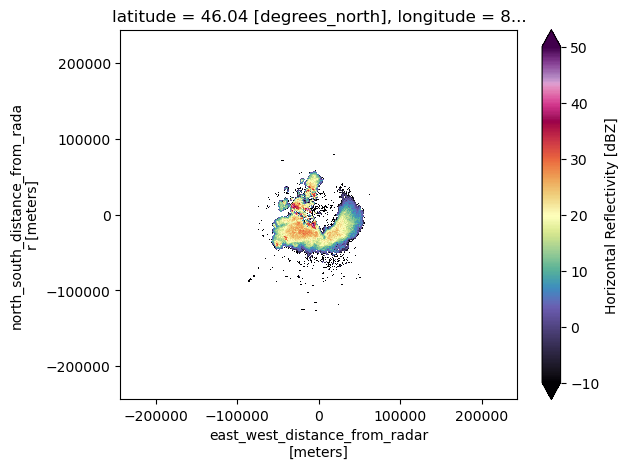

In [9]:
fig, ax = plt.subplots()
ds.isel(volume_time=1).reflectivity.plot(x="x", y="y", cmap="ChaseSpectral", vmin=-10, vmax=50)

In [10]:
ds.to_zarr()

In [11]:
ds.reflectivity.unify_chunks().hvplot.quadmesh(x="x", 
                                y="y", 
                                groupby="volume_time", 
                                widget_type="scrubber",
                                widget_location="bottom",
                                clim=(-10, 50),
                                cmap="ChaseSpectral"
                                # rasterize=True, 
                               )

Column
    [0] HoloViews(DynamicMap, height=300, sizing_mode='fixed', widget_location='bottom', widget_type='scrubber', width=700)
    [1] WidgetBox(align=('center', 'end'))
        [0] Player(end=72, width=550)

In [12]:
from xarray.backends.api import open_datatree

In [13]:
dt = open_datatree("/media/alfonso/drive/Alfonso/python/raw2zarr/zarr/Guaviare_V2.zarr", engine="zarr", chunks={})

In [14]:
dt

DataTree('None', parent=None)
│   Dimensions:              ()
│   Data variables:
│       altitude             float64 8B ...
│       instrument_type      <U5 20B ...
│       latitude             float64 8B ...
│       longitude            float64 8B ...
│       platform_type        <U5 20B ...
│       time_coverage_end    <U20 80B ...
│       time_coverage_start  <U20 80B ...
│       volume_number        int64 8B ...
│   Attributes:
│       Conventions:      None
│       comment:          im/exported using xradar
│       history:          None
│       institution:      None
│       instrument_name:  None
│       references:       None
│       source:           None
│       title:            None
│       version:          None
├── DataTree('radar_parameters')
│       Dimensions:    ()
│       Coordinates:
│           altitude   float64 8B ...
│           latitude   float64 8B ...
│           longitude  float64 8B ...
│       Data variables:
│           *empty*
├── DataTree('sweep_0')
│       Dimensions:            (vcp_time: 285, azimuth: 720, range: 994)
│       Coordinates:
│           altitude           float64 8B ...
│         * azimuth            (azimuth) float32 3kB 0.25 0.75 1.25 ... 359.2 359.8
│           crs_wkt            int64 8B ...
│           elevation          (azimuth) float64 6kB dask.array<chunksize=(720,), meta=np.ndarray>
│           latitude           float64 8B ...
│           longitude          float64 8B ...
│         * range              (range) float32 4kB 1e+03 1.3e+03 ... 2.986e+05 2.989e+05
│           time               (azimuth) datetime64[ns] 6kB dask.array<chunksize=(720,), meta=np.ndarray>
│         * vcp_time           (vcp_time) datetime64[ns] 2kB 2022-06-04T00:00:30.1300...
│           x                  (azimuth, range) float64 6MB dask.array<chunksize=(180, 249), meta=np.ndarray>
│           y                  (azimuth, range) float64 6MB dask.array<chunksize=(180, 249), meta=np.ndarray>
│           z                  (azimuth, range) float64 6MB dask.array<chunksize=(180, 249), meta=np.ndarray>
│       Data variables: (12/17)
│           DBTH               (vcp_time, azimuth, range) float32 816MB dask.array<chunksize=(1, 180, 497), meta=np.ndarray>
│           DBZH               (vcp_time, azimuth, range) float32 816MB dask.array<chunksize=(1, 180, 497), meta=np.ndarray>
│           DB_DBTE8           (vcp_time, azimuth, range) float32 816MB dask.array<chunksize=(1, 180, 497), meta=np.ndarray>
│           DB_DBZE8           (vcp_time, azimuth, range) float32 816MB dask.array<chunksize=(1, 180, 497), meta=np.ndarray>
│           DB_HCLASS          (vcp_time, azimuth, range) int16 408MB dask.array<chunksize=(1, 360, 497), meta=np.ndarray>
│           KDP                (vcp_time, azimuth, range) float32 816MB dask.array<chunksize=(1, 180, 497), meta=np.ndarray>
│           ...                 ...
│           ZDR                (vcp_time, azimuth, range) float32 816MB dask.array<chunksize=(1, 180, 497), meta=np.ndarray>
│           follow_mode        (vcp_time) <U7 8kB dask.array<chunksize=(1,), meta=np.ndarray>
│           prt_mode           (vcp_time) <U7 8kB dask.array<chunksize=(1,), meta=np.ndarray>
│           sweep_fixed_angle  (vcp_time) float64 2kB dask.array<chunksize=(1,), meta=np.ndarray>
│           sweep_mode         (vcp_time) <U20 23kB dask.array<chunksize=(1,), meta=np.ndarray>
│           sweep_number       (vcp_time) int64 2kB dask.array<chunksize=(1,), meta=np.ndarray>
├── DataTree('sweep_1')
│       Dimensions:            (vcp_time: 284, azimuth: 360, range: 747)
│       Coordinates:
│           altitude           float64 8B ...
│         * azimuth            (azimuth) float32 1kB 0.5 1.5 2.5 ... 357.5 358.5 359.5
│           crs_wkt            int64 8B ...
│           elevation          (azimuth) float64 3kB dask.array<chunksize=(360,), meta=np.ndarray>
│           latitude           float64 8B ...
│           longitude          float64 8B ...
│         * range      

In [15]:
ds = dt['sweep_0'].ds

In [16]:
ds

<xarray.DatasetView> Size: 9GB
Dimensions:            (vcp_time: 285, azimuth: 720, range: 994)
Coordinates:
    altitude           float64 8B ...
  * azimuth            (azimuth) float32 3kB 0.25 0.75 1.25 ... 359.2 359.8
    crs_wkt            int64 8B ...
    elevation          (azimuth) float64 6kB dask.array<chunksize=(720,), meta=np.ndarray>
    latitude           float64 8B ...
    longitude          float64 8B ...
  * range              (range) float32 4kB 1e+03 1.3e+03 ... 2.986e+05 2.989e+05
    time               (azimuth) datetime64[ns] 6kB dask.array<chunksize=(720,), meta=np.ndarray>
  * vcp_time           (vcp_time) datetime64[ns] 2kB 2022-06-04T00:00:30.1300...
    x                  (azimuth, range) float64 6MB dask.array<chunksize=(180, 249), meta=np.ndarray>
    y                  (azimuth, range) float64 6MB dask.array<chunksize=(180, 249), meta=np.ndarray>
    z                  (azimuth, range) float64 6MB dask.array<chunksize=(180, 249), meta=np.ndarray>
Data variables: (12/17)
    DBTH               (vcp_time, azimuth, range) float32 816MB dask.array<chunksize=(1, 180, 497), meta=np.ndarray>
    DBZH               (vcp_time, azimuth, range) float32 816MB dask.array<chunksize=(1, 180, 497), meta=np.ndarray>
    DB_DBTE8           (vcp_time, azimuth, range) float32 816MB dask.array<chunksize=(1, 180, 497), meta=np.ndarray>
    DB_DBZE8           (vcp_time, azimuth, range) float32 816MB dask.array<chunksize=(1, 180, 497), meta=np.ndarray>
    DB_HCLASS          (vcp_time, azimuth, range) int16 408MB dask.array<chunksize=(1, 360, 497), meta=np.ndarray>
    KDP                (vcp_time, azimuth, range) float32 816MB dask.array<chunksize=(1, 180, 497), meta=np.ndarray>
    ...                 ...
    ZDR                (vcp_time, azimuth, range) float32 816MB dask.array<chunksize=(1, 180, 497), meta=np.ndarray>
    follow_mode        (vcp_time) <U7 8kB dask.array<chunksize=(1,), meta=np.ndarray>
    prt_mode           (vcp_time) <U7 8kB dask.array<chunksize=(1,), meta=np.ndarray>
    sweep_fixed_angle  (vcp_time) float64 2kB dask.array<chunksize=(1,), meta=np.ndarray>
    sweep_mode         (vcp_time) <U20 23kB dask.array<chunksize=(1,), meta=np.ndarray>
    sweep_number       (vcp_time) int64 2kB dask.array<chunksize=(1,), meta=np.ndarray>

In [17]:
ds.DBZH.unify_chunks().hvplot.quadmesh(x="x", 
                                y="y", 
                                groupby="vcp_time", 
                                widget_type="scrubber",
                                widget_location="bottom",
                                clim=(-10, 50),
                                cmap="ChaseSpectral",
                                rasterize=True, 
                               )

Column
    [0] HoloViews(DynamicMap, height=300, sizing_mode='fixed', widget_location='bottom', widget_type='scrubber', width=700)
    [1] WidgetBox(align=('center', 'end'))
        [0] Player(end=284, width=550)

In [18]:
ds.DBZH

<xarray.DataArray 'DBZH' (vcp_time: 285, azimuth: 720, range: 994)> Size: 816MB
dask.array<open_dataset-DBZH, shape=(285, 720, 994), dtype=float32, chunksize=(1, 180, 497), chunktype=numpy.ndarray>
Coordinates:
    altitude   float64 8B ...
  * azimuth    (azimuth) float32 3kB 0.25 0.75 1.25 1.75 ... 358.8 359.2 359.8
    crs_wkt    int64 8B ...
    elevation  (azimuth) float64 6kB dask.array<chunksize=(720,), meta=np.ndarray>
    latitude   float64 8B ...
    longitude  float64 8B ...
  * range      (range) float32 4kB 1e+03 1.3e+03 1.6e+03 ... 2.986e+05 2.989e+05
    time       (azimuth) datetime64[ns] 6kB dask.array<chunksize=(720,), meta=np.ndarray>
  * vcp_time   (vcp_time) datetime64[ns] 2kB 2022-06-04T00:00:30.130000 ... 2...
    x          (azimuth, range) float64 6MB dask.array<chunksize=(180, 249), meta=np.ndarray>
    y          (azimuth, range) float64 6MB dask.array<chunksize=(180, 249), meta=np.ndarray>
    z          (azimuth, range) float64 6MB dask.array<chunksize=(180, 249), meta=np.ndarray>
Attributes:
    long_name:      Equivalent reflectivity factor H
    standard_name:  radar_equivalent_reflectivity_factor_h
    units:          dBZ